<h1 style="text-align: center;"> Fortune Finders: the living wage expedition </h1>
<h2 style="text-align: center;"> Empowering workers with concrete data to support fair salary negotiations.</h2>

<h3> Introduction </h3>

To achieve the goal specified above this notebook will utilize and cross examine, the data tables<br/>  from the MIT Living Wage Calculator with Census and BEA data. We will compare typical salaries<br/> by industry and state (adjusted for price parity) with living wage data to anwer the following questions: 
1. Which regions (state, county, Metro-city) offers the best salary-to-living-wage ratio for a typical industry?
1. How do do the ratios vary between geographic locations and occupations?

<a id = "toc"></a>
### Table of Contents
- [Imports and Raw Data Preview](#Topic0)
    - [Imports](#Topic01)
    - [Raw Data Preview](#Topic02)
- [MIT Data with Population](#Topic1)
    - [Census Population Data Clean and Prep](#Topic11)
    - [MIT Tables Merged With Census Populations](#Topic12)
- [MIT Data State Summaries](#Topic2)

<a id = "Topic0"></a> 

### Imports and Raw Data Preview
#### Imports

In [191]:
# version = 3.11.4

from matplotlib import gridspec
import altair as alt
import matplotlib.pyplot as plt
import geopandas as gpd
from numpy.random import randint
import numpy as np
from IPython.display import display, Markdown
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

alt.data_transformers.enable("vegafusion")

# Set up choropleth map
geojson_path = 'data/ne_110m_admin_1_states_provinces.shp'
states = gpd.read_file(geojson_path)
states = states.to_crs("EPSG:3395")
states['State Code'] = states['iso_3166_2'].str.split('-', expand=True)[1]
State_Codes=states[['name','State Code']].copy()

geojson_path2 = 'data/USA_Counties_(Generalized).shp'
counties = gpd.read_file(geojson_path2)
counties = counties.to_crs("EPSG:3395")
counties.rename(columns={'NAME':'name'},inplace=True)
counties=pd.merge(counties,State_Codes,left_on=["STATE_NAME"],right_on=['name'],how='left')

In [119]:
# BEA Data brought in here as csv to protect our API key
RPP = pd.read_csv('price_parities.csv')  # BEA Price parities: SARPP Table
# Average State Salary: SAINC5N Report
StateSalary = pd.read_csv('personal_income.csv')
SSRPP = pd.read_csv('combined.csv')  # Average State Salary adjusted by RPP
RPPSM = pd.read_csv('Countiesdf.CSV')

# MIT Living Wage Data
CostDF = pd.read_csv('createdassets/CostDF.csv')
SalaryDF = pd.read_csv('createdassets/SalaryDF.csv')
WageDF = pd.read_csv('createdassets/WageDF.csv')

for d in [CostDF, SalaryDF, WageDF]:
    d.drop(['Unnamed: 0'], axis=1, inplace=True)

# Census Data CountyPopUSCensus or CPUC

CPUC = pd.read_excel(
    'createdassets/CensusData/co-est2022-pop.xlsx',
    header=[3],
    skiprows=[4, 326, 3149, 3150, 3151, 3152, 3153]
    # 4: total of whole of united states
    # 326: District of Columbia
    # 3149-3153: Table footnotes captured below
)
CPUC.columns = ['Geographic Area', 'April 1, 2020 Estimates Base',
                'Population Estimate 2020', 'Population Estimate 2021', 'Population Estimate 2022']

<a id='Topic02'></a> 
#### Raw Data Preview
<a href='#toc'>TOC</a>

In [120]:
Tables = {
    "2022 Price Parities": RPP,
    "2022 Average State Salary": StateSalary,
    "Average State Salary adjusted by RPP": SSRPP,
    "MIT Living Wage: Wages by County": WageDF,
    "MIT Living Wage: Typical Expenses by County": CostDF,
    "MIT Living Wage: Occupation Salary by County": SalaryDF,
    "County Population US Census": CPUC
}

for title, table in Tables.items():
    display(Markdown('<br/><h5>{}</h5>'.format(title)))

    rows = 5
    if "Wages" in title:
        rows = 3
    if "Expenses" in title:
        rows = 10
    if "Occupation" in title:
        rows = 22
    display(table.head(rows))

<br/><h5>2022 Price Parities</h5>

Code  GeoFips        GeoName  TimePeriod CL_UNIT  UNIT_MULT  DataValue
0  SARPP-1        0  United States        2022   Index          0    100.000
1  SARPP-1     1000        Alabama        2022   Index          0     87.776
2  SARPP-1     2000         Alaska        2022   Index          0    101.989
3  SARPP-1     4000        Arizona        2022   Index          0     99.897
4  SARPP-1     5000       Arkansas        2022   Index          0     86.597

<br/><h5>2022 Average State Salary</h5>

Code  GeoFips        GeoName  TimePeriod  CL_UNIT  UNIT_MULT  \
0  SAINC5N-30        0  United States        2022  Dollars          0   
1  SAINC5N-30     1000        Alabama        2022  Dollars          0   
2  SAINC5N-30     2000         Alaska        2022  Dollars          0   
3  SAINC5N-30     4000        Arizona        2022  Dollars          0   
4  SAINC5N-30     5000       Arkansas        2022  Dollars          0   

   DataValue  NoteRef  
0      65470        3  
1      50916        3  
2      68635        3  
3      58442        3  
4      52618        3

<br/><h5>Average State Salary adjusted by RPP</h5>

State  Year   Income  Price Parities  Standardized Income
0        Wyoming  2022  73248.0          91.903             79701.42
1   North Dakota  2022  70360.0          88.656             79362.93
2    Connecticut  2022  82938.0         106.412             77940.46
3   South Dakota  2022  68176.0          87.991             77480.65
4  Massachusetts  2022  84561.0         109.393             77300.19

<br/><h5>MIT Living Wage: Wages by County</h5>

WageType 1 ADULT - 0 1 ADULT - 1 1 ADULT - 2 1 ADULT - 3  \
0   Living Wage     $16.04      $30.58      $37.60      $48.71    
1  Poverty Wage      $6.19       $8.38      $10.56      $12.74    
2  Minimum Wage      $7.25       $7.25       $7.25       $7.25    

  2 ADULTS(1 WORKING) - 0 2 ADULTS(1 WORKING) - 1 2 ADULTS(1 WORKING) - 2  \
0                 $25.52                  $30.31                  $35.73    
1                  $8.38                  $10.56                  $12.74    
2                  $7.25                   $7.25                   $7.25    

  2 ADULTS(1 WORKING) - 3 2 ADULTS(BOTH WORKING) - 0  \
0                 $38.52                     $12.76    
1                 $14.92                      $4.19    
2                  $7.25                      $7.25    

  2 ADULTS(BOTH WORKING) - 1 2 ADULTS(BOTH WORKING) - 2  \
0                    $17.01                     $21.58    
1                     $5.28                      $6.37    
2                     $7.25                      $7.25    

  2 ADULTS(BOTH WORKING) - 3    State   County  
0                    $24.83   Alabama  Autauga  
1                     $7.46   Alabama  Autauga  
2                     $7.25   Alabama  Autauga

<br/><h5>MIT Living Wage: Typical Expenses by County</h5>

CostType 1 ADULT - 0 1 ADULT - 1 1 ADULT - 2  \
0                                 Food     $3,351      $4,937      $7,417    
1                           Child Care         $0      $6,261     $12,521    
2                              Medical     $2,733      $7,921      $7,708    
3                              Housing     $8,310     $11,789     $11,789    
4                       Transportation     $5,509      $9,776     $12,709    
5                                Civic     $2,503      $4,019      $4,965    
6                                Other     $4,508      $6,723      $6,150    
7   Required annual income after taxes    $27,036     $51,550     $63,383    
8                         Annual taxes     $6,321     $12,053     $14,819    
9  Required annual income before taxes    $33,357     $63,602     $78,203    

  1 ADULT - 3 2 ADULTS(1 WORKING) - 0 2 ADULTS(1 WORKING) - 1  \
0     $9,838                  $6,143                  $7,645    
1    $18,782                      $0                      $0    
2     $8,018                  $6,298                  $7,708    
3    $14,906                  $9,946                 $11,789    
4    $15,012                  $9,776                 $12,709    
5     $6,483                  $4,019                  $4,965    
6     $8,948                  $6,723                  $6,150    
7    $82,110                 $43,027                 $51,090    
8    $19,198                 $10,060                 $11,945    
9   $101,308                 $53,087                 $63,035    

  2 ADULTS(1 WORKING) - 2 2 ADULTS(1 WORKING) - 3 2 ADULTS(BOTH WORKING) - 0  \
0                 $9,856                 $11,999                     $6,143    
1                     $0                      $0                         $0    
2                 $8,018                  $7,807                     $6,298    
3                $11,789                 $14,906                     $9,946    
4                $15,012                 $16,304                     $9,776    
5                 $6,483                  $5,153                     $4,019    
6                 $8,948                  $8,655                     $6,723    
7                $60,230                 $64,946                    $43,027    
8                $14,082                 $15,185                    $10,060    
9                $74,312                 $80,131                    $53,087    

  2 ADULTS(BOTH WORKING) - 1 2 ADULTS(BOTH WORKING) - 2  \
0                    $7,645                     $9,856    
1                    $6,261                    $12,521    
2                    $7,708                     $8,018    
3                   $11,789                    $11,789    
4                   $12,709                    $15,012    
5                    $4,965                     $6,483    
6                    $6,150                     $8,948    
7                   $57,351                    $72,751    
8                   $13,409                    $17,010    
9                   $70,760                    $89,760    

  2 ADULTS(BOTH WORKING) - 3    State   County  
0                   $11,999   Alabama  Autauga  
1                   $18,782   Alabama  Autauga  
2                    $7,807   Alabama  Autauga  
3                   $14,906   Alabama  Autauga  
4                   $16,304   Alabama  Autauga  
5                    $5,153   Alabama  Autauga  
6                    $8,655   Alabama  Autauga  
7                   $83,728   Alabama  Autauga  
8                   $19,576   Alabama  Autauga  
9                  $103,304   Alabama  Autauga

<br/><h5>MIT Living Wage: Occupation Salary by County</h5>

Occupational Area Typical Annual Salary  \
0                                          Management             $101,778    
1                 Business &amp; Financial Operations              $71,198    
2                         Computer &amp; Mathematical              $86,938    
3                      Architecture &amp; Engineering              $90,447    
4                Life, Physical, &amp; Social Science              $64,992    
5                      Community &amp; Social Service              $47,059    
6                                               Legal              $69,240    
7                  Education, Training, &amp; Library              $54,260    
8    Arts, Design, Entertainment, Sports, &amp; Media              $41,698    
9            Healthcare Practitioners &amp; Technical              $58,080    
10                                 Healthcare Support              $26,055    
11                                 Protective Service              $39,975    
12             Food Preparation &amp; Serving Related              $20,812    
13  Building &amp; Grounds Cleaning &amp; Maintenance              $26,108    
14                        Personal Care &amp; Service              $23,925    
15                                Sales &amp; Related              $28,291    
16                Office &amp; Administrative Support              $36,829    
17                   Farming, Fishing, &amp; Forestry              $32,132    
18                      Construction &amp; Extraction              $42,490    
19            Installation, Maintenance, &amp; Repair              $48,910    
20                                         Production              $36,123    
21               Transportation &amp; Material Moving              $32,175    

      State   County  
0   Alabama  Autauga  
1   Alabama  Autauga  
2   Alabama  Autauga  
3   Alabama  Autauga  
4   Alabama  Autauga  
5   Alabama  Autauga  
6   Alabama  Autauga  
7   Alabama  Autauga  
8   Alabama  Autauga  
9   Alabama  Autauga  
10  Alabama  Autauga  
11  Alabama  Autauga  
12  Alabama  Autauga  
13  Alabama  Autauga  
14  Alabama  Autauga  
15  Alabama  Autauga  
16  Alabama  Autauga  
17  Alabama  Autauga  
18  Alabama  Autauga  
19  Alabama  Autauga  
20  Alabama  Autauga  
21  Alabama  Autauga

<br/><h5>County Population US Census</h5>

Geographic Area  April 1, 2020 Estimates Base  \
0  .Autauga County, Alabama                         58802   
1  .Baldwin County, Alabama                        231761   
2  .Barbour County, Alabama                         25224   
3     .Bibb County, Alabama                         22300   
4   .Blount County, Alabama                         59130   

   Population Estimate 2020  Population Estimate 2021  \
0                     58902                     59210   
1                    233219                    239361   
2                     24960                     24539   
3                     22183                     22370   
4                     59102                     59085   

   Population Estimate 2022  
0                     59759  
1                    246435  
2                     24706  
3                     22005  
4                     59512

<a id = "Topic1"></a>

### MIT Data with Population
#### Add county populations
*Population via Census merged to MIT Tables:
Cost, Salary and Wage tables from the MIT Living Wage Data set will be combined with county population via Census

<a id = "Topic11"></a>

#### Clean up CPUC for merge
1. define split function
2. split data
3. check for missing rows between MIT data and Census
4. examine  differences, revisit and modify step 2 until all MIT rows match
5. Inner merge MIT Table and CPUC Tables

<a href='#toc'>TOC</a>

In [121]:
# Function to split the 'Geographic Area'[column in CPUC] into 'County' and 'State'
def split_geographic_area(area):

    # Strip leading periods and whitespace
    area_cleaned = area.strip('.').strip()
    # Most pairs have format [County equivalent],[state]
    parts = area_cleaned.split(',')

    # If there's no comma or an unexpected format, return placeholders indicating a need for manual review
    if len(parts) != 2:
        return ['Invalid Format - Review Needed', 'Invalid Format - Review Needed']
    # Trim whitespace from parts to ensure clean data
    county, state = parts[0].strip(), parts[1].strip()
    return county, state

In [122]:
CPUC_1 = CPUC.copy()  # maintain original

# split the 'Geographic Area' into 'County' and 'State'
CPUC_1[['County Equivalent', 'State']] = CPUC_1.apply(
    lambda row: split_geographic_area(row['Geographic Area']), axis=1, result_type='expand')
# merge destination has the word "County stripped from county entries (although maintains other title like "Parish")"
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(
    ' County', '', regex=False)
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(
    ' Borough', '', regex=False)
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(
    ' Census Area', '', regex=False)
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(
    ' Parish', '', regex=False)
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(
    ' Planning Region', '', regex=False)

# Connecticut uses regions instead of counties we'll approximately correct for this
CT_rename_map = {
    "Northwest Hills": "Litchfield",
    "Naugatuck Valley": "New Haven",
    "South Central Connecticut": "New Haven",
    "Western Connecticut": "Fairfield",
    "Greater Bridgeport": "Fairfield",
    "Lower Connecticut River Valley": "Middlesex",
    "Southeastern Connecticut": "New London",
    "Northeastern Connecticut": "Windham"
}

for old_name, new_name in CT_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Connecticut') & (CPUC_1['County Equivalent'].str.contains(
        old_name, case=False)), 'County Equivalent'] = new_name

# Connecticut census combines Tolland and Haartford counties. I'm going to drop capitol and manualy add them
CPUC_1 = CPUC_1[~((CPUC_1['County Equivalent'] == 'Capitol')
                  & (CPUC_1['State'] == 'Connecticut'))]

# Add new entries for Hartford and Tolland
new_rows = pd.DataFrame([
    [".Hartford County, Connecticut", 897932, 897932,
        898636, 898636, "Hartford", "Connecticut"],
    [".Tolland County, Connecticut", 149650, 149650,
        150293, 150120, "Tolland", "Connecticut"]
], columns=['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate 2020', 'Population Estimate 2021', 'Population Estimate 2022', 'County Equivalent', 'State'])

CPUC_1 = pd.concat([CPUC_1, new_rows], ignore_index=True)

# Alaska corrections
AK_rename_map = {
    "Anchorage Municipality": "Valdez-Cordova",
    "Chugach": "Valdez-Cordova",
    "Copper River": "Valdez-Cordova"
}

for old_name, new_name in AK_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Alaska') & (CPUC_1['County Equivalent'].str.contains(
        old_name, case=False)), 'County Equivalent'] = new_name


# Virginia Corrections
VI_rename_map = {
    "Alexandria city": "Alexandria",
    "Bristol city": "Bristol",
    "Buena Vista city": "Buena Vista",
    "Charlottesville city": "Charlottesville",
    "Chesapeake city": "Chesapeake",
    "Colonial Heights city": "Colonial Heights",
    "Covington city": "Covington",
    "Danville city": "Danville",
    "Emporia city": "Emporia",
    "Falls Church city": "Falls Church",
    "Fredericksburg city": "Fredericksburg",
    "Galax city": "Galax",
    "Hampton city": "Hampton",
    "Harrisonburg city": "Harrisonburg",
    "Hopewell city": "Hopewell",
    "Lexington city": "Lexington",
    "Lynchburg city": "Lynchburg",
    "Manassas Park city": "Manassas Park",
    "Manassas city": "Manassas",
    "Martinsville city": "Martinsville",
    "Newport News city": "Newport News",
    "Norfolk city": "Norfolk",
    "Norton city": "Norton",
    "Petersburg city": "Petersburg",
    "Radford city": "Poquoson",
    "Richmond city": "Portsmouth",
    "Roanoke city": "Radford",
    "Salem city": "Salem",
    "Staunton city": "Staunton",
    "Suffolk city": "Suffolk",
    "Virginia Beach city": "Virginia Beach",
    "Waynesboro city": "Waynesboro",
    "Williamsburg city": "Williamsburg",
    "Winchester city": "Winchester"
}

for old_name, new_name in VI_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Virginia') & (CPUC_1['County Equivalent'].str.contains(
        old_name, case=False)), 'County Equivalent'] = new_name


# duplicates now exist form some counties lets aggregate
aggregated_df = CPUC_1.groupby(['County Equivalent', 'State']).agg({
    'April 1, 2020 Estimates Base': 'sum',
    'Population Estimate 2020': 'sum',
    'Population Estimate 2021': 'sum',
    'Population Estimate 2022': 'sum'
}).reset_index()
aggregated_df['Geographic Area'] = aggregated_df['County Equivalent'] + \
    " , " + aggregated_df['State']
aggregated_df = aggregated_df[['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate 2020',
                               'Population Estimate 2021', 'Population Estimate 2022', 'County Equivalent', 'State']]
CPUC_1 = aggregated_df


CPUC_1_Invalid = len(
    CPUC_1[CPUC_1['County Equivalent'] == 'Invalid Format - Review Needed'])
CPUC_1_Valid = len(CPUC) - CPUC_1_Invalid

print(f'Number of total counties: {len(CPUC_1)}')
print(f'Number of valid county-state splits: {CPUC_1_Valid}')
print(f'Number of invalid county-state splits: {CPUC_1_Invalid}')

CPUC_1.head(20)

Number of total counties: 3140
Number of valid county-state splits: 3143
Number of invalid county-state splits: 0


Geographic Area  April 1, 2020 Estimates Base  \
0   Abbeville , South Carolina                         24287   
1           Acadia , Louisiana                         57569   
2          Accomack , Virginia                         33417   
3                  Ada , Idaho                        494964   
4                 Adair , Iowa                          7498   
5             Adair , Kentucky                         18903   
6             Adair , Missouri                         25315   
7             Adair , Oklahoma                         19494   
8             Adams , Colorado                        519582   
9                Adams , Idaho                          4380   
10            Adams , Illinois                         65727   
11             Adams , Indiana                         35811   
12                Adams , Iowa                          3708   
13         Adams , Mississippi                         29538   
14            Adams , Nebraska                         31202   
15        Adams , North Dakota                          2200   
16                Adams , Ohio                         27474   
17        Adams , Pennsylvania                        103829   
18          Adams , Washington                         20612   
19           Adams , Wisconsin                         20646   

    Population Estimate 2020  Population Estimate 2021  \
0                      24256                     24258   
1                      57472                     57262   
2                      33388                     33364   
3                     498260                    512914   
4                       7494                      7538   
5                      18880                     18953   
6                      25269                     25179   
7                      19451                     19479   
8                     520479                    523592   
9                       4425                      4632   
10                     65612                     65146   
11                     35852                     35939   
12                      3710                      3642   
13                     29419                     28804   
14                     31177                     30990   
15                      2187                      2152   
16                     27440                     27513   
17                    103779                    105632   
18                     20608                     20640   
19                     20675                     20795   

    Population Estimate 2022 County Equivalent           State  
0                      24356         Abbeville  South Carolina  
1                      56744            Acadia       Louisiana  
2                      33191          Accomack        Virginia  
3                     518907               Ada           Idaho  
4                       7494             Adair            Iowa  
5                      19067             Adair        Kentucky  
6                      25165             Adair        Missouri  
7                      19576             Adair        Oklahoma  
8                     527575             Adams        Colorado  
9                       4817             Adams           Idaho  
10                     64725             Adams        Illinois  
11                     36068             Adams         Indiana  
12                      3611             Adams            Iowa  
13                     28408             Adams     Mississippi  
14                     30970             Adams        Nebraska  
15                      2115             Adams    North Dakota  
16                     27420             Adams            Ohio  
17                    106027             Adams    Pennsylvania  
18                     20961             Adams      Washington  
19                     21226             Adams       Wisconsin

In [123]:
# we will merge several dfs on state and county
# lets examine thier sizes
print(
    f'WageDF has {len(WageDF[["County", "State"]].copy().drop_duplicates())} counties')
print(
    f'CostDF has {len(CostDF[["County", "State"]].copy().drop_duplicates())} counties')
print(
    f'SalaryDF has {len(SalaryDF[["County", "State"]].copy().drop_duplicates())} counties')

WageDF has 3115 counties
CostDF has 3115 counties
SalaryDF has 3115 counties


In [124]:
# lets examine missing pairings
# Create unique state-county identifiers for each dataset
WageDF['State-County'] = WageDF['State'] + '-' + WageDF['County']
CPUC_1['State-County'] = CPUC_1['State'] + '-' + CPUC_1['County Equivalent']

wage_unique_pairings = set(WageDF['State-County'])
census_unique_pairings = set(CPUC_1['State-County'])
merged_unique_pairings = set(WageDF['State'] + '-' + WageDF['County']) & set(
    CPUC_1['State'] + '-' + CPUC_1['County Equivalent'])

# Identify missing pairings in merged_df from both wage_df and census_df_cleaned
missing_in_merged_from_wage = wage_unique_pairings - merged_unique_pairings
missing_in_merged_from_census = census_unique_pairings - merged_unique_pairings

# Filter wage_df and census_df_cleaned for the missing pairings
missing_rows_wage_df = WageDF[WageDF['State-County']
                              .isin(missing_in_merged_from_wage)]
missing_rows_census_df_cleaned = CPUC_1[CPUC_1['State-County'].isin(
    missing_in_merged_from_census)]


# Display the count of missing rows for each dataset to understand the scope
M_MIT = missing_rows_wage_df[["County", "State"]].copy().drop_duplicates()
M_CPUC = missing_rows_census_df_cleaned[[
    "County Equivalent", "State"]].copy().drop_duplicates()

# from here we'll compare and loop back to and modify CPUC_1 definition until all counties from wage_df are matched
display(Markdown('<br/><h5>{}: {}</h5>'.format("Unmatched MIT counties", len(M_MIT))))
display(M_MIT.head(30))
display(Markdown('<br/><h5>{}: {}</h5>'.format("Unmatched Census counties", len(M_CPUC))))
display(M_CPUC.sort_values('State').head(30))

<br/><h5>Unmatched MIT counties: 0</h5>

Empty DataFrame
Columns: [County, State]
Index: []

<br/><h5>Unmatched Census counties: 25</h5>

County Equivalent         State
3114      Yakutat City and        Alaska
2617  Skagway Municipality        Alaska
2615        Sitka City and        Alaska
1457       Juneau City and        Alaska
3102     Wrangell City and        Alaska
2236            Petersburg        Alaska
3006               Webster       Georgia
840                 Echols       Georgia
2367               Quitman       Georgia
1460               Kalawao        Hawaii
1543               LaSalle      Illinois
1544               LaSalle     Louisiana
2629              Somerset         Maine
2273           Piscataquis         Maine
1665               Lincoln         Maine
122         Baltimore city      Maryland
2664        St. Louis city      Missouri
815               Doña Ana    New Mexico
271                Bristol  Rhode Island
1073            Grand Isle       Vermont
2311         Poquoson city      Virginia
2316       Portsmouth city      Virginia
976          Franklin city      Virginia
895           Fairfax city      Virginia
1383            James City      Virginia

Our dataset is missing some counties and we're unable to reconcile them. The original MIT data for this analysis came from a data pull in May 2022. Since that pull it has been noticed on the MIT Living Wage Calculator website that they request no web scrapping. We submitted a request to thier API but haven't heard back likely due to the fact they update thier tables yearly in January. As such we will use the data we have and respect thier wishes. The data is still public and could be grabbed table by table without the API via copy paste. So we press on to merge the data

<a name = "Topic12"></a>

### MIT Data With Population Tables

<a href='#toc'>TOC</a>

In [125]:
CPUC_1 = CPUC_1[["Population Estimate 2022", "County Equivalent", "State"]]

WageDFwithPop = pd.merge(CPUC_1, WageDF, left_on=[
                         'State', 'County Equivalent'], right_on=['State', 'County'], how='inner')
CostDFwithPop = pd.merge(CPUC_1, CostDF, left_on=[
                         'State', 'County Equivalent'], right_on=['State', 'County'], how='inner')
SalaryDFwithPop = pd.merge(CPUC_1, SalaryDF, left_on=[
                           'State', 'County Equivalent'], right_on=['State', 'County'], how='inner')


display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Wages by County and Population")))
display(WageDFwithPop.head(3))
display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Typical Expenses by County and Population")))
display(CostDFwithPop.head(10))
display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Occupation Salary by County and Population")))
display(SalaryDFwithPop.head(22))

<br/><h5>MIT Living Wage: Wages by County and Population</h5>

Population Estimate 2022 County Equivalent           State      WageType  \
0                     24356         Abbeville  South Carolina   Living Wage   
1                     24356         Abbeville  South Carolina  Poverty Wage   
2                     24356         Abbeville  South Carolina  Minimum Wage   

  1 ADULT - 0 1 ADULT - 1 1 ADULT - 2 1 ADULT - 3 2 ADULTS(1 WORKING) - 0  \
0     $15.57      $29.48      $35.86      $46.84                  $24.67    
1      $6.19       $8.38      $10.56      $12.74                   $8.38    
2      $7.25       $7.25       $7.25       $7.25                   $7.25    

  2 ADULTS(1 WORKING) - 1 2 ADULTS(1 WORKING) - 2 2 ADULTS(1 WORKING) - 3  \
0                 $30.03                  $35.59                  $38.88    
1                 $10.56                  $12.74                  $14.92    
2                  $7.25                   $7.25                   $7.25    

  2 ADULTS(BOTH WORKING) - 0 2 ADULTS(BOTH WORKING) - 1  \
0                    $12.33                     $16.51    
1                     $4.19                      $5.28    
2                     $7.25                      $7.25    

  2 ADULTS(BOTH WORKING) - 2 2 ADULTS(BOTH WORKING) - 3     County  \
0                    $20.78                     $23.91   Abbeville   
1                     $6.37                      $7.46   Abbeville   
2                     $7.25                      $7.25   Abbeville   

               State-County  
0  South Carolina-Abbeville  
1  South Carolina-Abbeville  
2  South Carolina-Abbeville

<br/><h5>MIT Living Wage: Typical Expenses by County and Population</h5>

Population Estimate 2022 County Equivalent           State  \
0                     24356         Abbeville  South Carolina   
1                     24356         Abbeville  South Carolina   
2                     24356         Abbeville  South Carolina   
3                     24356         Abbeville  South Carolina   
4                     24356         Abbeville  South Carolina   
5                     24356         Abbeville  South Carolina   
6                     24356         Abbeville  South Carolina   
7                     24356         Abbeville  South Carolina   
8                     24356         Abbeville  South Carolina   
9                     24356         Abbeville  South Carolina   

                              CostType 1 ADULT - 0 1 ADULT - 1 1 ADULT - 2  \
0                                 Food     $3,351      $4,937      $7,417    
1                           Child Care         $0      $4,903      $9,805    
2                              Medical     $2,957      $9,182      $8,969    
3                              Housing     $6,648      $8,816      $8,816    
4                       Transportation     $5,509      $9,776     $12,709    
5                                Civic     $2,503      $4,019      $4,965    
6                                Other     $4,508      $6,723      $6,150    
7   Required annual income after taxes    $25,599     $48,479     $58,955    
8                         Annual taxes     $6,784     $12,848     $15,624    
9  Required annual income before taxes    $32,383     $61,327     $74,579    

  1 ADULT - 3 2 ADULTS(1 WORKING) - 0 2 ADULTS(1 WORKING) - 1  \
0     $9,838                  $6,143                  $7,645    
1    $14,708                      $0                      $0    
2     $9,278                  $7,086                  $8,969    
3    $12,620                  $6,687                  $8,816    
4    $15,012                  $9,776                 $12,709    
5     $6,483                  $4,019                  $4,965    
6     $8,948                  $6,723                  $6,150    
7    $77,011                 $40,556                 $49,377    
8    $20,410                 $10,748                 $13,086    
9    $97,421                 $51,304                 $62,463    

  2 ADULTS(1 WORKING) - 2 2 ADULTS(1 WORKING) - 3 2 ADULTS(BOTH WORKING) - 0  \
0                 $9,856                 $11,999                     $6,143    
1                     $0                      $0                         $0    
2                 $9,278                  $9,067                     $7,086    
3                 $8,816                 $12,620                     $6,687    
4                $15,012                 $16,304                     $9,776    
5                 $6,483                  $5,153                     $4,019    
6                 $8,948                  $8,655                     $6,723    
7                $58,517                 $63,922                    $40,556    
8                $15,508                 $16,941                    $10,748    
9                $74,025                 $80,862                    $51,304    

  2 ADULTS(BOTH WORKING) - 1 2 ADULTS(BOTH WORKING) - 2  \
0                    $7,645                     $9,856    
1                    $4,903                     $9,805    
2                    $8,969                     $9,278    
3                    $8,816                     $8,816    
4                   $12,709                    $15,012    
5                    $4,965                     $6,483    
6                    $6,150                     $8,948    
7                   $54,280                    $68,322    
8                   $14,385                    $18,107    
9                   $68,666                    $86,429    

  2 ADULTS(BOTH WORKING) - 3     County  
0                   $11,999   Abbeville  
1                   $14,708   Abbeville  
2                    $9,067   Abbeville  
3            

<br/><h5>MIT Living Wage: Occupation Salary by County and Population</h5>

Population Estimate 2022 County Equivalent           State  \
0                      24356         Abbeville  South Carolina   
1                      24356         Abbeville  South Carolina   
2                      24356         Abbeville  South Carolina   
3                      24356         Abbeville  South Carolina   
4                      24356         Abbeville  South Carolina   
5                      24356         Abbeville  South Carolina   
6                      24356         Abbeville  South Carolina   
7                      24356         Abbeville  South Carolina   
8                      24356         Abbeville  South Carolina   
9                      24356         Abbeville  South Carolina   
10                     24356         Abbeville  South Carolina   
11                     24356         Abbeville  South Carolina   
12                     24356         Abbeville  South Carolina   
13                     24356         Abbeville  South Carolina   
14                     24356         Abbeville  South Carolina   
15                     24356         Abbeville  South Carolina   
16                     24356         Abbeville  South Carolina   
17                     24356         Abbeville  South Carolina   
18                     24356         Abbeville  South Carolina   
19                     24356         Abbeville  South Carolina   
20                     24356         Abbeville  South Carolina   
21                     24356         Abbeville  South Carolina   

                                    Occupational Area Typical Annual Salary  \
0                                          Management             $101,928    
1                 Business &amp; Financial Operations              $67,464    
2                         Computer &amp; Mathematical              $77,329    
3                      Architecture &amp; Engineering              $80,999    
4                Life, Physical, &amp; Social Science              $64,457    
5                      Community &amp; Social Service              $42,212    
6                                               Legal              $62,777    
7                  Education, Training, &amp; Library              $49,958    
8    Arts, Design, Entertainment, Sports, &amp; Media              $45,250    
9            Healthcare Practitioners &amp; Technical              $65,891    
10                                 Healthcare Support              $28,869    
11                                 Protective Service              $39,098    
12             Food Preparation &amp; Serving Related              $21,764    
13  Building &amp; Grounds Cleaning &amp; Maintenance              $26,836    
14                        Personal Care &amp; Service              $26,055    
15                                Sales &amp; Related              $28,847    
16                Office &amp; Administrative Support              $37,611    
17                   Farming, Fishing, &amp; Forestry              $31,833    
18                      Construction &amp; Extraction              $42,757    
19            Installation, Maintenance, &amp; Repair              $47,776    
20                                         Production              $39,847    
21               Transportation &amp; Material Moving              $32,624    

       County  
0   Abbeville  
1   Abbeville  
2   Abbeville  
3   Abbeville  
4   Abbeville  
5   Abbeville  
6   Abbeville  
7   Abbeville  
8   Abbeville  
9   Abbeville  
10  Abbeville  
11  Abbeville  
12  Abbeville  
13  Abbeville  
14  Abbeville  
15  Abbeville  
16  Abbeville  
17  Abbeville  
18  Abbeville  
19  Abbeville  
20  Abbeville  
21  Abbeville

<a id = Topic2></a>

### MIT Data State Summaries
#### County data Projected up to state level
*weighting projection by county population

<a href='#toc'>TOC</a>

#### State Data Aggregation for cost and wage

In [126]:
CostDFwithPop = CostDFwithPop[['Population Estimate 2022', 'State', 'CostType', 'County', '1 ADULT - 0', '1 ADULT - 1', '1 ADULT - 2', '1 ADULT - 3',
                               '2 ADULTS(1 WORKING) - 0', '2 ADULTS(1 WORKING) - 1', '2 ADULTS(1 WORKING) - 2', '2 ADULTS(1 WORKING) - 3',
                               '2 ADULTS(BOTH WORKING) - 0', '2 ADULTS(BOTH WORKING) - 1', '2 ADULTS(BOTH WORKING) - 2', '2 ADULTS(BOTH WORKING) - 3']]

StateNames = CostDFwithPop['State'].unique()
NewCostDF = pd.DataFrame()
for state in StateNames:
    Dfstate = CostDFwithPop[CostDFwithPop['State'] == state]

    # Calculate the total population for the state
    StatePopSum = Dfstate['Population Estimate 2022'].sum(
    )/len(Dfstate['CostType'].unique())

    # Initialize an empty DataFrame for the new state data
    NewStateDF = pd.DataFrame(columns=Dfstate.columns.drop(
        ['State', 'County', 'Population Estimate 2022']))
    
    # Aggregate cost data for the state, adjusting by population weight
    for cost_type in Dfstate['CostType'].unique():
        cost_data = Dfstate[Dfstate['CostType'] == cost_type].copy()
        
        # Excluding 'Unnamed: 0', 'Population Estimate 2022', 'State', 'CostType', 'County'
        monetary_columns = cost_data.columns[4:]
        cost_data[monetary_columns] = cost_data[monetary_columns].replace(
            '[\$,]', '', regex=True).astype(float)
        weighted_costs = cost_data[monetary_columns].apply(lambda x: (
            x * cost_data['Population Estimate 2022']).sum() / StatePopSum, axis=0)
        weighted_costs_dict = weighted_costs.to_dict()
        weighted_costs_dict['CostType'] = cost_type
        assert isinstance(
            NewStateDF, pd.DataFrame), "NewStateDF is not a DataFrame"
        NewStateDF = pd.concat([NewStateDF, pd.DataFrame(
            [weighted_costs_dict])], ignore_index=True)

    # Add the state name and population to the aggregated data
    NewStateDF['State'] = state
    NewStateDF['Population Estimate 2022'] = StatePopSum

    # Append the processed state data to the new DataFrame
    NewCostDF = pd.concat([NewCostDF, NewStateDF], ignore_index=True)

# Display the first few rows of the aggregated DataFrame to verify the results
StateCostDF = NewCostDF


NewCostDF.head()

CostType  1 ADULT - 0   1 ADULT - 1   1 ADULT - 2   1 ADULT - 3  \
0            Food  3351.000000   4937.000000   7417.000000   9838.000000   
1      Child Care     0.000000   5609.889415  11219.580293  16829.469708   
2         Medical  2957.000000   9182.000000   8969.000000   9278.000000   
3         Housing  9828.407409  12200.552331  12200.552331  15917.694809   
4  Transportation  5509.000000   9776.000000  12709.000000  15012.000000   

   2 ADULTS(1 WORKING) - 0  2 ADULTS(1 WORKING) - 1  2 ADULTS(1 WORKING) - 2  \
0              6143.000000              7645.000000              9856.000000   
1                 0.000000                 0.000000                 0.000000   
2              7086.000000              8969.000000              9278.000000   
3             10451.640438             12200.552331             12200.552331   
4              9776.000000             12709.000000             15012.000000   

   2 ADULTS(1 WORKING) - 3  2 ADULTS(BOTH WORKING) - 0  \
0             11999.000000                 6143.000000   
1                 0.000000                    0.000000   
2              9067.000000                 7086.000000   
3             15917.694809                10451.640438   
4             16304.000000                 9776.000000   

   2 ADULTS(BOTH WORKING) - 1  2 ADULTS(BOTH WORKING) - 2  \
0                 7645.000000                 9856.000000   
1                 5609.889415                11219.580293   
2                 8969.000000                 9278.000000   
3                12200.552331                12200.552331   
4                12709.000000                15012.000000   

   2 ADULTS(BOTH WORKING) - 3           State  Population Estimate 2022  
0                11999.000000  South Carolina                 5282634.0  
1                16829.469708  South Carolina                 5282634.0  
2                 9067.000000  South Carolina                 5282634.0  
3                15917.694809  South Carolina                 5282634.0  
4                16304.000000  South Carolina                 5282634.0

In [127]:
WageDFwithPop = WageDFwithPop[['Population Estimate 2022', 'State', 'WageType', 'County',
                               '1 ADULT - 0', '1 ADULT - 1', '1 ADULT - 2', '1 ADULT - 3',
                               '2 ADULTS(1 WORKING) - 0', '2 ADULTS(1 WORKING) - 1',
                               '2 ADULTS(1 WORKING) - 2', '2 ADULTS(1 WORKING) - 3',
                               '2 ADULTS(BOTH WORKING) - 0', '2 ADULTS(BOTH WORKING) - 1',
                               '2 ADULTS(BOTH WORKING) - 2', '2 ADULTS(BOTH WORKING) - 3']]

NewWageDF = pd.DataFrame()

# Assuming WageDFwithPop has already had 'County Equivalent' and 'State-County' dropped
StateNames = WageDFwithPop['State'].unique()
NewWageDF = pd.DataFrame()
for state in StateNames:
    Dfstate = WageDFwithPop[WageDFwithPop['State'] == state].copy()

    # Calculate the total population for the state
    StatePopSum = Dfstate['Population Estimate 2022'].sum(
    )/len(WageDFwithPop['WageType'].unique())

    # Initialize an empty DataFrame for the new state data
    columns_to_keep = Dfstate.columns.drop(
        ['State', 'County', 'Population Estimate 2022'])
    NewStateDF = pd.DataFrame(columns=columns_to_keep)

    # Prepare wage data, adjusting by population weight
    for wage_type in Dfstate['WageType'].unique():
        wage_data = Dfstate[Dfstate['WageType'] == wage_type].copy()

        # Adjust index based on your DataFrame structure
        monetary_columns = wage_data.columns[4:]
        wage_data[monetary_columns] = wage_data[monetary_columns].replace(
            '[\$,]', '', regex=True).astype(float)
        weighted_wages = wage_data[monetary_columns].apply(
            lambda x: (x * wage_data['Population Estimate 2022']).sum() / StatePopSum, axis=0)
        weighted_wages_dict = weighted_wages.to_dict()
        weighted_wages_dict['WageType'] = wage_type
        NewStateDF = pd.concat([NewStateDF, pd.DataFrame(
            [weighted_wages_dict])], ignore_index=True)

    # Add the state name and total population to the aggregated data
    NewStateDF['State'] = state
    NewStateDF['Population Estimate 2022'] = StatePopSum

    # Append the processed state data to the new DataFrame
    NewWageDF = pd.concat([NewWageDF, NewStateDF], ignore_index=True)

StateWageDF = NewWageDF
NewWageDF.head()

WageType  1 ADULT - 0  1 ADULT - 1  1 ADULT - 2  1 ADULT - 3  \
0   Living Wage    17.503204    31.971810    38.774883    50.131148   
1  Poverty Wage     6.190000     8.380000    10.560000    12.740000   
2  Minimum Wage     7.250000     7.250000     7.250000     7.250000   
3   Living Wage    16.165557    32.212301    39.759239    51.688243   
4  Poverty Wage     6.190000     8.380000    10.560000    12.740000   

   2 ADULTS(1 WORKING) - 0  2 ADULTS(1 WORKING) - 1  2 ADULTS(1 WORKING) - 2  \
0                26.954471                32.088533                37.648038   
1                 8.380000                10.560000                12.740000   
2                 7.250000                 7.250000                 7.250000   
3                25.820630                31.495922                36.985592   
4                 8.380000                10.560000                12.740000   

   2 ADULTS(1 WORKING) - 3  2 ADULTS(BOTH WORKING) - 0  \
0                40.880712                   13.477657   
1                14.920000                    4.190000   
2                 7.250000                    7.250000   
3                40.059957                   12.911322   
4                14.920000                    4.190000   

   2 ADULTS(BOTH WORKING) - 1  2 ADULTS(BOTH WORKING) - 2  \
0                   17.751381                   22.236004   
1                    5.280000                    6.370000   
2                    7.250000                    7.250000   
3                   17.848505                   22.692651   
4                    5.280000                    6.370000   

   2 ADULTS(BOTH WORKING) - 3           State  Population Estimate 2022  
0                   25.557895  South Carolina                 5282634.0  
1                    7.460000  South Carolina                 5282634.0  
2                    7.250000  South Carolina                 5282634.0  
3                   26.329214       Louisiana                 4575512.0  
4                    7.460000       Louisiana                 4575512.0

#### State Salary Data
One thing we'd come to find out is that salaries arn't estimated by occupation at the county level, instead the statewide estimates are reiteriated for each county. We feel this finding is related to the ethics issues we raised in our proposal. There are some rual counties in the USA where very few individuals work in certain occupations. It's likely the MIT team didn't drill down into county level data here due to privacy concerns. It is possible this data could be aggregated  through a combination of unsupervised and supervised learning combined with BLS statistics however, If the MIT team didn't do it we probably shouldn't either.

In [128]:
StateSalary = SalaryDFwithPop.copy()
StateSalary['Typical Annual Salary'] = StateSalary['Typical Annual Salary'].str.strip(
).str.replace(',', '').str.replace('$', '').astype(int)
StateSalary.head()
StateSalary = StateSalary.groupby(['State', 'Occupational Area']).agg(
    {'Population Estimate 2022': 'sum', 'Typical Annual Salary': 'sum', 'Typical Annual Salary': lambda x: sum(
    x * SalaryDFwithPop.loc[x.index, 'Population Estimate 2022']) / sum(SalaryDFwithPop.loc[x.index, 'Population Estimate 2022'])}).reset_index()

#### MIT State Summary Tables

In [129]:

display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Wages by State and Population")))
display(StateWageDF.sort_values('State').tail(20))
display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Typical Expenses by State and Population")))
display(StateCostDF.head(10))
display(Markdown(
    '<br/><h5>{}</h5>'.format("MIT Living Wage: Occupation Salary by State and Population")))
display(StateSalary.head(22))

<br/><h5>MIT Living Wage: Wages by State and Population</h5>

WageType  1 ADULT - 0  1 ADULT - 1  1 ADULT - 2  1 ADULT - 3  \
123   Living Wage    16.970373    32.224769    40.241966    53.862918   
125  Minimum Wage     7.250000     7.250000     7.250000     7.250000   
56   Minimum Wage    12.550000    12.550000    12.550000    12.550000   
55   Poverty Wage     6.190000     8.380000    10.560000    12.740000   
54    Living Wage    17.793632    35.932227    45.284144    60.464967   
6     Living Wage    19.455604    36.265467    45.581247    60.354566   
7    Poverty Wage     6.190000     8.380000    10.560000    12.740000   
8    Minimum Wage    11.000000    11.000000    11.000000    11.000000   
49   Poverty Wage     6.190000     8.380000    10.560000    12.740000   
48    Living Wage    18.522908    34.333513    42.927727    58.249327   
50   Minimum Wage    14.490000    14.490000    14.490000    14.490000   
117   Living Wage    15.475221    31.131661    39.776676    52.617577   
119  Minimum Wage     8.750000     8.750000     8.750000     8.750000   
118  Poverty Wage     6.190000     8.380000    10.560000    12.740000   
52   Poverty Wage     6.190000     8.380000    10.560000    12.740000   
53   Minimum Wage     7.250000     7.250000     7.250000     7.250000   
51    Living Wage    16.410442    33.243204    42.683062    56.900410   
72    Living Wage    15.253858    29.901198    37.815798    50.395964   
73   Poverty Wage     6.190000     8.380000    10.560000    12.740000   
74   Minimum Wage     7.250000     7.250000     7.250000     7.250000   

     2 ADULTS(1 WORKING) - 0  2 ADULTS(1 WORKING) - 1  \
123                26.134343                31.186941   
125                 7.250000                 7.250000   
56                 12.550000                12.550000   
55                  8.380000                10.560000   
54                 28.168395                33.523242   
6                  27.975266                33.761462   
7                   8.380000                10.560000   
8                  11.000000                11.000000   
49                  8.380000                10.560000   
48                 27.182340                32.317273   
50                 14.490000                14.490000   
117                24.657034                29.316051   
119                 8.750000                 8.750000   
118                 8.380000                10.560000   
52                  8.380000                10.560000   
53                  7.250000                 7.250000   
51                 25.355160                30.623610   
72                 23.631090                28.560130   
73                  8.380000                10.560000   
74                  7.250000                 7.250000   

     2 ADULTS(1 WORKING) - 2  2 ADULTS(1 WORKING) - 3  \
123                36.832720                41.130937   
125                 7.250000                 7.250000   
56                 12.550000                12.550000   
55                 12.740000                14.920000   
54                 39.501280                42.832811   
6                  39.232419                43.386171   
7                  12.740000                14.920000   
8                  11.000000                11.000000   
49                 12.740000                14.920000   
48                 37.639313                43.138255   
50                 14.490000                14.490000   
117                34.904471                37.791463   
119                 8.750000                 8.750000   
118                12.740000                14.920000   
52                 12.740000                14.920000   
53                  7.250000                 7.250000   
51                 36.343610                39.426337   
72                 33.880809                37.317655   
73                 12.740000                14.920000   
74                  7.250000                 7.250000   

     2 ADULTS(BOTH WORKING) - 0  2 ADULTS(BOTH WORKING) - 1  \
123             

<br/><h5>MIT Living Wage: Typical Expenses by State and Population</h5>

CostType   1 ADULT - 0   1 ADULT - 1  \
0                                 Food   3351.000000   4937.000000   
1                           Child Care      0.000000   5609.889415   
2                              Medical   2957.000000   9182.000000   
3                              Housing   9828.407409  12200.552331   
4                       Transportation   5509.000000   9776.000000   
5                                Civic   2503.000000   4019.000000   
6                                Other   4508.000000   6723.000000   
7   Required annual income after taxes  28779.328545  52570.426477   
8                         Annual taxes   7627.074616  13932.317552   
9  Required annual income before taxes  36406.406425  66502.581846   

    1 ADULT - 2    1 ADULT - 3  2 ADULTS(1 WORKING) - 0  \
0   7417.000000    9838.000000              6143.000000   
1  11219.580293   16829.469708                 0.000000   
2   8969.000000    9278.000000              7086.000000   
3  12200.552331   15917.694809             10451.640438   
4  12709.000000   15012.000000              9776.000000   
5   4965.000000    6483.000000              4019.000000   
6   6150.000000    8948.000000              6723.000000   
7  63753.390054   82430.105953             44320.834205   
8  16896.043510   21845.917305             11746.004772   
9  80649.464619  104276.063840             56066.815028   

   2 ADULTS(1 WORKING) - 1  2 ADULTS(1 WORKING) - 2  2 ADULTS(1 WORKING) - 3  \
0              7645.000000              9856.000000             11999.000000   
1                 0.000000                 0.000000                 0.000000   
2              8969.000000              9278.000000              9067.000000   
3             12200.552331             12200.552331             15917.694809   
4             12709.000000             15012.000000             16304.000000   
5              4965.000000              6483.000000              5153.000000   
6              6150.000000              8948.000000              8655.000000   
7             52761.687250             61901.333720             67219.023661   
8             13982.900844             16405.232944             17814.591408   
9             66744.474960             78306.474960             85033.415583   

   2 ADULTS(BOTH WORKING) - 0  2 ADULTS(BOTH WORKING) - 1  \
0                 6143.000000                 7645.000000   
1                    0.000000                 5609.889415   
2                 7086.000000                 8969.000000   
3                10451.640438                12200.552331   
4                 9776.000000                12709.000000   
5                 4019.000000                 4965.000000   
6                 6723.000000                 6150.000000   
7                44320.834205                58371.576666   
8                11746.004772                15469.598219   
9                56066.815028                73841.181109   

   2 ADULTS(BOTH WORKING) - 2  2 ADULTS(BOTH WORKING) - 3           State  \
0                 9856.000000                11999.000000  South Carolina   
1                11219.580293                16829.469708  South Carolina   
2                 9278.000000                 9067.000000  South Carolina   
3                12200.552331                15917.694809  South Carolina   
4                15012.000000                16304.000000  South Carolina   
5                 6483.000000                 5153.000000  South Carolina   
6                 8948.000000                 8655.000000  South Carolina   
7                73120.914012                84048.493369  South Carolina   
8                19378.660306                22274.621166  South Carolina   
9                92499.464619               106323.271967  South Carolina   

   Population Estimate 2022  
0                 5282634.0  
1                 5282634.0  
2                 5282634.0  
3                 5282634.0  
4                 5282634.0  
5                 5282634.0 

<br/><h5>MIT Living Wage: Occupation Salary by State and Population</h5>

State                                  Occupational Area  \
0   Alabama                     Architecture &amp; Engineering   
1   Alabama   Arts, Design, Entertainment, Sports, &amp; Media   
2   Alabama  Building &amp; Grounds Cleaning &amp; Maintenance   
3   Alabama                Business &amp; Financial Operations   
4   Alabama                     Community &amp; Social Service   
5   Alabama                        Computer &amp; Mathematical   
6   Alabama                      Construction &amp; Extraction   
7   Alabama                 Education, Training, &amp; Library   
8   Alabama                   Farming, Fishing, &amp; Forestry   
9   Alabama             Food Preparation &amp; Serving Related   
10  Alabama           Healthcare Practitioners &amp; Technical   
11  Alabama                                 Healthcare Support   
12  Alabama            Installation, Maintenance, &amp; Repair   
13  Alabama                                              Legal   
14  Alabama               Life, Physical, &amp; Social Science   
15  Alabama                                         Management   
16  Alabama                Office &amp; Administrative Support   
17  Alabama                        Personal Care &amp; Service   
18  Alabama                                         Production   
19  Alabama                                 Protective Service   
20  Alabama                                Sales &amp; Related   
21  Alabama               Transportation &amp; Material Moving   

    Population Estimate 2022  Typical Annual Salary  
0                    5074296                90447.0  
1                    5074296                41698.0  
2                    5074296                26108.0  
3                    5074296                71198.0  
4                    5074296                47059.0  
5                    5074296                86938.0  
6                    5074296                42490.0  
7                    5074296                54260.0  
8                    5074296                32132.0  
9                    5074296                20812.0  
10                   5074296                58080.0  
11                   5074296                26055.0  
12                   5074296                48910.0  
13                   5074296                69240.0  
14                   5074296                64992.0  
15                   5074296               101778.0  
16                   5074296                36829.0  
17                   5074296                23925.0  
18                   5074296                36123.0  
19                   5074296                39975.0  
20                   5074296                28291.0  
21                   5074296                32175.0

## Visuals
### Preprocessing
#### County Level

In [130]:
#select columns by specify columns not to select
def SelectOtherColums(df,ColumnsNotToSelect):
    otherColumns = [col for col in df.columns if col not in ColumnsNotToSelect]
    return otherColumns

df = CostDFwithPop.copy()
df.head()

Population Estimate 2022           State        CostType     County  \
0                     24356  South Carolina            Food  Abbeville   
1                     24356  South Carolina      Child Care  Abbeville   
2                     24356  South Carolina         Medical  Abbeville   
3                     24356  South Carolina         Housing  Abbeville   
4                     24356  South Carolina  Transportation  Abbeville   

  1 ADULT - 0 1 ADULT - 1 1 ADULT - 2 1 ADULT - 3 2 ADULTS(1 WORKING) - 0  \
0     $3,351      $4,937      $7,417      $9,838                  $6,143    
1         $0      $4,903      $9,805     $14,708                      $0    
2     $2,957      $9,182      $8,969      $9,278                  $7,086    
3     $6,648      $8,816      $8,816     $12,620                  $6,687    
4     $5,509      $9,776     $12,709     $15,012                  $9,776    

  2 ADULTS(1 WORKING) - 1 2 ADULTS(1 WORKING) - 2 2 ADULTS(1 WORKING) - 3  \
0                 $7,645                  $9,856                 $11,999    
1                     $0                      $0                      $0    
2                 $8,969                  $9,278                  $9,067    
3                 $8,816                  $8,816                 $12,620    
4                $12,709                 $15,012                 $16,304    

  2 ADULTS(BOTH WORKING) - 0 2 ADULTS(BOTH WORKING) - 1  \
0                    $6,143                     $7,645    
1                        $0                     $4,903    
2                    $7,086                     $8,969    
3                    $6,687                     $8,816    
4                    $9,776                    $12,709    

  2 ADULTS(BOTH WORKING) - 2 2 ADULTS(BOTH WORKING) - 3  
0                    $9,856                    $11,999   
1                    $9,805                    $14,708   
2                    $9,278                     $9,067   
3                    $8,816                    $12,620   
4                   $15,012                    $16,304

In [155]:
# We're going to make a Data Long of this information so then with a
# couple filters and pivots we can generate any view we want

#1) prep costs
#   a) Melt Houshold values
#   b) correct Currency formatting and rename for concat
#   c) calc total costs for household
#   d) calc average of costs over household
MeltedCostsCounty = pd.melt(CostDFwithPop,
                             id_vars=['State', 'County', 'Population Estimate 2022','CostType'],
                             var_name='Household', value_name='Amount')
MeltedCostsCounty['CostType'] = MeltedCostsCounty['CostType'] + ' Cost'
MeltedCostsCounty['Amount'] = MeltedCostsCounty['Amount'].str.replace('$', '')
MeltedCostsCounty['Amount'] = MeltedCostsCounty['Amount'].str.replace( ',', '').astype(float)
MeltedCostsCounty.rename(columns={'CostType': 'Measure'}, inplace=True)
MeltedCostsCounty = MeltedCostsCounty[MeltedCostsCounty.Measure != 'Required annual income after taxes Cost']
MeltedCostsCounty = MeltedCostsCounty[MeltedCostsCounty.Measure != 'Required annual income before taxes Cost']
#total costs for each household
MeltedCostsCounty['Total Cost'] = MeltedCostsCounty.groupby(SelectOtherColums(MeltedCostsCounty,['Measure','Amount']))['Amount'].transform('sum')
MeltedCostsCounty = MeltedCostsCounty.pivot(index=SelectOtherColums(MeltedCostsCounty,['Measure','Amount']),columns=['Measure'], values=['Amount']).reset_index()
MeltedCostsCounty.columns = [lvl1 if lvl1 else lvl0 for lvl0, lvl1 in  MeltedCostsCounty.columns]
MeltedCostsCounty =pd.melt(MeltedCostsCounty,
                             id_vars=['State', 'County', 'Population Estimate 2022','Household'],
                             var_name='Measure', value_name='Amount')
#average costs over household
MeltedCostsCounty['Household Average'] = MeltedCostsCounty.groupby(SelectOtherColums(MeltedCostsCounty,['Household','Amount']))['Amount'].transform('mean')
MeltedCostsCounty = MeltedCostsCounty.pivot(index=SelectOtherColums(MeltedCostsCounty,['Household','Amount']),columns=['Household'], values=['Amount']).reset_index()
MeltedCostsCounty.columns = [lvl1 if lvl1 else lvl0 for lvl0, lvl1 in  MeltedCostsCounty.columns]
MeltedCostsCounty =pd.melt(MeltedCostsCounty,
                             id_vars=['State', 'County', 'Population Estimate 2022','Measure'],
                             var_name='Household', value_name='Amount')
MeltedCostsCounty['Amount']=MeltedCostsCounty['Amount'].round(2)
display(MeltedCostsCounty.head())



MeltedWagesCounty = pd.melt(WageDFwithPop,
                             id_vars=['State', 'County', 'Population Estimate 2022','WageType'],
                             var_name='Household', value_name='Amount')
MeltedWagesCounty['Amount'] = MeltedWagesCounty['Amount'].str.replace('$', '')
MeltedWagesCounty['Amount'] = MeltedWagesCounty['Amount'].str.replace(',', '').astype(float) * 2080
MeltedWagesCounty.rename(columns={'WageType': 'Measure'}, inplace=True)
#average wages over household
MeltedWagesCounty['Household Average'] = MeltedWagesCounty.groupby(SelectOtherColums(MeltedWagesCounty,['Household','Amount']))['Amount'].transform('mean')
MeltedWagesCounty = MeltedWagesCounty.pivot(index=SelectOtherColums(MeltedWagesCounty,['Household','Amount']),columns=['Household'], values=['Amount']).reset_index()
MeltedWagesCounty.columns = [lvl1 if lvl1 else lvl0 for lvl0, lvl1 in  MeltedWagesCounty.columns]
MeltedWagesCounty =pd.melt(MeltedWagesCounty,
                             id_vars=['State', 'County', 'Population Estimate 2022','Measure'],
                             var_name='Household', value_name='Amount')
MeltedWagesCounty['Amount']=MeltedWagesCounty['Amount'].round(2)
display(MeltedWagesCounty.head())

#2) subselect relevant salary columns and clean up currency
SalaryCounty = SalaryDFwithPop[[
    'State', 'County', 'Occupational Area', 'Typical Annual Salary']].copy()
SalaryCounty['Occupational Area'] = SalaryCounty['Occupational Area'].str.replace(
    '&amp;', 'and', regex=False)
SalaryCounty['Typical Annual Salary'] = SalaryCounty['Typical Annual Salary'].str.replace(
    '$', '')
SalaryCounty['Typical Annual Salary'] = SalaryCounty['Typical Annual Salary'].str.replace(
    ',', '').astype(float)

display(SalaryCounty.head())

#3) Create Long
#   a) Merge RPP and Salary County on 'State' 
#   b) concatenate costs and wages table
#   c) join the two tables
CountyMetrics = pd.concat([MeltedCostsCounty, MeltedWagesCounty]).set_index(['State', 'County']).join(
    SalaryCounty.set_index('State').join(
        RPP.drop(
            RPP[(RPP['GeoName'] == 'United States') & (
                RPP['GeoName'] == 'District of Columbia')].index
        )[['GeoName', 'DataValue']].copy().set_index('GeoName'),
        how='inner',
        validate="many_to_one"
    ).set_index(["County"], append=True),
    how="inner",
    validate="many_to_many"
).reset_index()

#4) rename columns and add parity adj columns
CountyMetrics.rename(columns={'DataValue': 'RPP'}, inplace=True)
CountyMetrics['std Amount'] = CountyMetrics['Amount'] * \
    (CountyMetrics['RPP']/100)
CountyMetrics['std Salary'] = CountyMetrics['Typical Annual Salary'] * \
    (CountyMetrics['RPP']/100)

AmountColumns = ['Amount','std Amount']
SalColumns = ['Typical Annual Salary', 'std Salary']

#5) Melt the DataFrame to stack Amounts and Salaries
#   and order columns from lowest to highest granularity
CountyMetrics = pd.melt(CountyMetrics, id_vars=SelectOtherColums(CountyMetrics,SalColumns),
                    value_vars=['Typical Annual Salary', 'std Salary'], var_name='Salary Type', value_name='Salary')
CountyMetrics = pd.melt(CountyMetrics, id_vars=SelectOtherColums(CountyMetrics,AmountColumns),
                    value_vars=AmountColumns, var_name='Measure Type', value_name='Measure Value')
CountyMetrics = CountyMetrics[['State','County','Population Estimate 2022','RPP','Occupational Area',
                               'Salary Type', 'Salary', 'Household', 'Measure','Measure Type','Measure Value']]
CountyMetrics.head()

State   County  Population Estimate 2022            Measure  \
0  Alabama  Autauga                     59759  Annual taxes Cost   
1  Alabama  Autauga                     59759    Child Care Cost   
2  Alabama  Autauga                     59759         Civic Cost   
3  Alabama  Autauga                     59759          Food Cost   
4  Alabama  Autauga                     59759       Housing Cost   

           Household    Amount  
0  Household Average  13643.17  
1  Household Average   6260.67  
2  Household Average   4934.17  
3  Household Average   8069.08  
4  Household Average  11971.17

State   County  Population Estimate 2022       Measure  \
0  Alabama  Autauga                     59759   Living Wage   
1  Alabama  Autauga                     59759  Minimum Wage   
2  Alabama  Autauga                     59759  Poverty Wage   
3  Alabama  Baldwin                    246435   Living Wage   
4  Alabama  Baldwin                    246435  Minimum Wage   

           Household    Amount  
0  Household Average  58792.93  
1  Household Average  15080.00  
2  Household Average  18680.13  
3  Household Average  59403.07  
4  Household Average  15080.00

State     County                   Occupational Area  \
0  South Carolina  Abbeville                          Management   
1  South Carolina  Abbeville   Business and Financial Operations   
2  South Carolina  Abbeville           Computer and Mathematical   
3  South Carolina  Abbeville        Architecture and Engineering   
4  South Carolina  Abbeville  Life, Physical, and Social Science   

   Typical Annual Salary  
0               101928.0  
1                67464.0  
2                77329.0  
3                80999.0  
4                64457.0

State   County  Population Estimate 2022     RPP  \
0  Alabama  Autauga                     59759  87.776   
1  Alabama  Autauga                     59759  87.776   
2  Alabama  Autauga                     59759  87.776   
3  Alabama  Autauga                     59759  87.776   
4  Alabama  Autauga                     59759  87.776   

                    Occupational Area            Salary Type    Salary  \
0                          Management  Typical Annual Salary  101778.0   
1   Business and Financial Operations  Typical Annual Salary   71198.0   
2           Computer and Mathematical  Typical Annual Salary   86938.0   
3        Architecture and Engineering  Typical Annual Salary   90447.0   
4  Life, Physical, and Social Science  Typical Annual Salary   64992.0   

           Household            Measure Measure Type  Measure Value  
0  Household Average  Annual taxes Cost       Amount       13643.17  
1  Household Average  Annual taxes Cost       Amount       13643.17  
2  Household Average  Annual taxes Cost       Amount       13643.17  
3  Household Average  Annual taxes Cost       Amount       13643.17  
4  Household Average  Annual taxes Cost       Amount       13643.17

#### State Level

In [156]:
# Data long form
MeltedCosts = pd.melt(StateCostDF,
                      id_vars=['State', 'Population Estimate 2022', 'CostType'],
                      var_name='Household',
                      value_name='Cost')
MeltedCosts['Num Adults in Household'] = MeltedCosts['Household'].apply(
    lambda x: x.split(' ')[0])
MeltedCosts['Num of working Adults in Household'] = MeltedCosts['Household'].apply(
    lambda x: 1 if '2 ADULTS(1 WORKING)' in x else 2 if '2 ADULTS(BOTH WORKING)' in x else 1)
MeltedCosts['Num of children in Household'] = MeltedCosts['Household'].apply(
    lambda x: x.split(' ')[-1])
MeltedCosts.drop(MeltedCosts[MeltedCosts['CostType'] ==
                 'Required annual income after taxes'].index, inplace=True)
MeltedCosts.drop(MeltedCosts[MeltedCosts['CostType'] ==
                 'Required annual income before taxes'].index, inplace=True)
MeltedCosts['CostType'] = MeltedCosts['CostType'] + ' Cost'
MeltedCosts.drop('Household', axis=1, inplace=True)
MeltedCosts.rename(columns={'Cost': 'Amount'}, inplace=True)
MeltedCosts.rename(columns={'CostType': 'Variable'}, inplace=True)
display(MeltedCosts.head())

MeltedWages = pd.melt(StateWageDF, id_vars=[
                      'State', 'Population Estimate 2022', 'WageType'], var_name='Household', value_name='Earnings')
MeltedWages['Num Adults in Household'] = MeltedWages['Household'].apply(
    lambda x: x.split(' ')[0])
MeltedWages['Num of working Adults in Household'] = MeltedWages['Household'].apply(
    lambda x: 1 if '2 ADULTS(1 WORKING)' in x else 2 if '2 ADULTS(BOTH WORKING)' in x else 1)
MeltedWages['Num of children in Household'] = MeltedWages['Household'].apply(
    lambda x: x.split(' ')[-1])
MeltedWages.drop('Household', axis=1, inplace=True)
# taking wages to annual
MeltedWages['Earnings'] = MeltedWages['Earnings'] * 2080
# adjusting for dual income
MeltedWages.loc[MeltedWages['Num of working Adults in Household']
                == 2, 'Earnings'] *= 2
MeltedWages.rename(columns={'Earnings': 'Amount'}, inplace=True)
MeltedWages.rename(columns={'WageType': 'Variable'}, inplace=True)
display(MeltedWages.head())

StateSalary['Occupational Area'] = StateSalary['Occupational Area'].str.replace(
    '&amp;', 'and', regex=False)
display(StateSalary.head())


Parity_merger = RPP[['GeoName', 'DataValue']].copy()
Parity_merger.rename(
    columns={'GeoName': 'State', 'DataValue': 'RPP'}, inplace=True)

# merging Parity to MIT
CostParity = pd.merge(Parity_merger, MeltedCosts,
                      left_on='State', right_on='State', how='inner')
display(CostParity.sample(10))
WageParity = pd.merge(Parity_merger, MeltedWages,
                      left_on='State', right_on='State', how='inner')
display(WageParity.sample(10))
OccupationParity = pd.merge(
    Parity_merger, StateSalary, left_on='State', right_on='State', how='inner')


# standardizing $ by parity
# IVP_Cost = CostParity.rename({'DataValue': 'RPP'}, axis = 'columns')
CostParity["std Costs"] = (CostParity["Amount"] /
                           (CostParity["RPP"]/100)).round()
CostParity.sort_values(by="std Costs", ascending=False, inplace=True)


# IVP_Wage = WageParity.rename({'DataValue':'RPP'}, axis = 'columns')
WageParity["std wages"] = (WageParity["Amount"] /
                           (WageParity["RPP"]/100)).round()
WageParity.sort_values(by="std wages", ascending=False, inplace=True)


# IVP_OCC = OccupationParity.rename({'DataValue':'RPP'}, axis = 'columns')
OccupationParity["std Salaries"] = (
    OccupationParity["Typical Annual Salary"] / (OccupationParity["RPP"]/100)).round()
OccupationParity.sort_values(by="std Salaries", ascending=False, inplace=True)


# Total Household expenditures
IVP_Cost_Total = CostParity.groupby(['State', "Population Estimate 2022", 'Num Adults in Household',
                                    'Num of working Adults in Household', 'Num of children in Household']).agg({'std Costs': 'sum'}).reset_index()
# merge total expenditures with Wage and compare via divison across all households
WageVCost = pd.merge(WageParity, IVP_Cost_Total, left_on=['State', 'Num Adults in Household', 'Num of working Adults in Household', 'Num of children in Household'], right_on=[
                     'State', 'Num Adults in Household', 'Num of working Adults in Household', 'Num of children in Household'], how='inner')
# WageVCost = pd.concat([WageParity, IVP_Cost_Total,])
WageVCost['IncomeVExpenses'] = (WageVCost['std wages'] - WageVCost['std Costs'])/(
    WageVCost['std wages'] + WageVCost['std Costs'])


# compare occupation with wage and cost data. applying filter to not make huge table
# pick occupation
occupations = [
    'Management', 'Computer and Mathematical',
    'Architecture and Engineering', 'Legal',
    'Healthcare Practitioners and Technical',
    'Life, Physical, and Social Science',
    'Business and Financial Operations',
    'Construction and Extraction',
    'Arts, Design, Entertainment, Sports, and Media',
    'Education, Training, and Library',
    'Community and Social Service',
    'Installation, Maintenance, and Repair',
    'Production', 'Protective Service',
    'Transportation and Material Moving',
    'Farming, Fishing, and Forestry',
    'Office and Administrative Support',
    'Healthcare Support', 'Sales and Related',
    'Building and Grounds Cleaning and Maintenance',
    'Personal Care and Service',
    'Food Preparation and Serving Related']

# Occupation = 'Computer and Mathematical'
# WageVCost2 = WageVCost[WageVCost["Num of working Adults in Household"]!=2]
display(WageVCost)
WageVCostVOCC = pd.merge(WageVCost, OccupationParity, left_on=[
                         'State'], right_on=['State'], how='inner')
display(WageVCostVOCC)

WageVCostVOCC = WageVCostVOCC[['State', 'Variable', 'Num Adults in Household', 'Num of working Adults in Household',
                               'Num of children in Household', 'Occupational Area', 'std wages', 'std Costs', 'std Salaries', 'Population Estimate 2022']]
WageVCostVOCC['HouseHold'] = 'Adults: ' + WageVCostVOCC['Num Adults in Household'].astype(str)  \
    + np.where(WageVCostVOCC['Num of working Adults in Household'] == 1, ', Sole Income, ', ', Dual Income, ') \
    + WageVCostVOCC['Num of children in Household'].astype(str) + ' kids'
WageVCostVOCC.drop(['Num Adults in Household', 'Num of working Adults in Household',
                   'Num of children in Household'], axis=1, inplace=True)

WageVCostVOCC.head()

State  Population Estimate 2022             Variable       Amount  \
0  South Carolina                 5282634.0            Food Cost  3351.000000   
1  South Carolina                 5282634.0      Child Care Cost     0.000000   
2  South Carolina                 5282634.0         Medical Cost  2957.000000   
3  South Carolina                 5282634.0         Housing Cost  9828.407409   
4  South Carolina                 5282634.0  Transportation Cost  5509.000000   

  Num Adults in Household  Num of working Adults in Household  \
0                       1                                   1   
1                       1                                   1   
2                       1                                   1   
3                       1                                   1   
4                       1                                   1   

  Num of children in Household  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

State  Population Estimate 2022      Variable        Amount  \
0  South Carolina                 5282634.0   Living Wage  36406.663852   
1  South Carolina                 5282634.0  Poverty Wage  12875.200000   
2  South Carolina                 5282634.0  Minimum Wage  15080.000000   
3       Louisiana                 4575512.0   Living Wage  33624.359178   
4       Louisiana                 4575512.0  Poverty Wage  12875.200000   

  Num Adults in Household  Num of working Adults in Household  \
0                       1                                   1   
1                       1                                   1   
2                       1                                   1   
3                       1                                   1   
4                       1                                   1   

  Num of children in Household  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

State                               Occupational Area  \
0  Alabama                    Architecture and Engineering   
1  Alabama  Arts, Design, Entertainment, Sports, and Media   
2  Alabama   Building and Grounds Cleaning and Maintenance   
3  Alabama               Business and Financial Operations   
4  Alabama                    Community and Social Service   

   Population Estimate 2022  Typical Annual Salary  
0                   5074296                90447.0  
1                   5074296                41698.0  
2                   5074296                26108.0  
3                   5074296                71198.0  
4                   5074296                47059.0

State      RPP  Population Estimate 2022             Variable  \
1570   Kentucky   89.356                 4512310.0         Medical Cost   
3525     Oregon  106.565                 4240137.0           Civic Cost   
2154  Minnesota   97.722                 5717184.0         Medical Cost   
3369   Oklahoma   88.771                 4019800.0      Child Care Cost   
2085   Michigan   93.428                10034113.0           Civic Cost   
3019   New York  107.599                19677151.0         Housing Cost   
564    Colorado  102.293                 5839926.0  Transportation Cost   
540    Colorado  102.293                 5839926.0  Transportation Cost   
4182       Utah   94.471                 3380800.0           Other Cost   
834     Florida  102.144                22244823.0         Medical Cost   

            Amount Num Adults in Household  \
1570   5529.000000                       2   
3525   4144.000000                       2   
2154   7359.000000                       2   
3369   7316.680452                       1   
2085   4646.000000                       2   
3019  21718.240520                       2   
564   13456.000000                       2   
540   14613.000000                       2   
4182   9424.000000                       2   
834    6908.000000                       2   

      Num of working Adults in Household Num of children in Household  
1570                                   1                            0  
3525                                   2                            0  
2154                                   1                            1  
3369                                   1                            1  
2085                                   2                            0  
3019                                   1                            1  
564                                    2                            2  
540                                    1                            3  
4182                                   1                            2  
834                                    2                            0

State      RPP  Population Estimate 2022      Variable  \
1412  South Carolina   93.551                 5282634.0  Minimum Wage   
1231            Ohio   91.450                11756058.0  Poverty Wage   
1564            Utah   94.471                 3380800.0  Poverty Wage   
469          Indiana   91.817                 6833037.0  Poverty Wage   
434         Illinois  101.257                12473954.0  Minimum Wage   
945         Nebraska   89.806                 1967923.0   Living Wage   
484          Indiana   91.817                 6833037.0  Poverty Wage   
404            Idaho   91.827                 1939033.0  Minimum Wage   
1762       Wisconsin   92.310                 5892539.0  Poverty Wage   
247      Connecticut  106.412                 3693514.0  Poverty Wage   

             Amount Num Adults in Household  \
1412   15080.000000                       1   
1231   21964.800000                       1   
1564   21964.800000                       2   
469    12875.200000                       1   
434    24960.000000                       1   
945   112644.611106                       1   
484    21964.800000                       2   
404    15080.000000                       1   
1762   31033.600000                       2   
247    26499.200000                       2   

      Num of working Adults in Household Num of children in Household  
1412                                   1                            2  
1231                                   1                            2  
1564                                   1                            1  
469                                    1                            0  
434                                    1                            0  
945                                    1                            3  
484                                    1                            1  
404                                    1                            2  
1762                                   2                            3  
247                                    2                            2

State      RPP  Population Estimate 2022_x      Variable  \
0     Massachusetts  109.393                   6981974.0   Living Wage   
1     Massachusetts  109.393                   6981974.0   Living Wage   
2          Michigan   93.428                  10034113.0   Living Wage   
3          Michigan   93.428                  10034113.0   Living Wage   
4        California  112.470                  39029342.0   Living Wage   
...             ...      ...                         ...           ...   
1795  New Hampshire  107.644                   1395231.0  Poverty Wage   
1796     New Jersey  108.757                   9261699.0  Poverty Wage   
1797  Massachusetts  109.393                   6981974.0  Poverty Wage   
1798     Washington  109.849                   7785786.0  Poverty Wage   
1799     California  112.470                  39029342.0  Poverty Wage   

             Amount Num Adults in Household  \
0     160432.269695                       2   
1     158893.566746                       1   
2     133662.527570                       2   
3     131971.974070                       1   
4     155857.081930                       2   
...             ...                     ...   
1795   12875.200000                       1   
1796   12875.200000                       1   
1797   12875.200000                       1   
1798   12875.200000                       1   
1799   12875.200000                       1   

      Num of working Adults in Household Num of children in Household  \
0                                      2                            3   
1                                      1                            3   
2                                      2                            3   
3                                      1                            3   
4                                      2                            3   
...                                  ...                          ...   
1795                                   1                            0   
1796                                   1                            0   
1797                                   1                            0   
1798                                   1                            0   
1799                                   1                            0   

      std wages  Population Estimate 2022_y  std Costs  IncomeVExpenses  
0      146657.0                   6981974.0   146544.0         0.000385  
1      145250.0                   6981974.0   145139.0         0.000382  
2      143065.0                  10034113.0   142933.0         0.000462  
3      141255.0                  10034113.0   141125.0         0.000460  
4      138577.0                  39029342.0   138466.0         0.000401  
...         ...                         ...        ...              ...  
1795    11961.0                   1395231.0    33356.0        -0.472119  
1796    11839.0                   9261699.0    38991.0        -0.534173  
1797    11770.0                   6981974.0    41455.0        -0.557727  
1798    11721.0                   7785786.0    34962.0        -0.497847  
1799    11448.0                  39029342.0    40433.0        -0.558682  

[1800 rows x 12 columns]

State    RPP_x  Population Estimate 2022_x      Variable  \
0      Massachusetts  109.393                   6981974.0   Living Wage   
1      Massachusetts  109.393                   6981974.0   Living Wage   
2      Massachusetts  109.393                   6981974.0   Living Wage   
3      Massachusetts  109.393                   6981974.0   Living Wage   
4      Massachusetts  109.393                   6981974.0   Living Wage   
...              ...      ...                         ...           ...   
39595     California  112.470                  39029342.0  Poverty Wage   
39596     California  112.470                  39029342.0  Poverty Wage   
39597     California  112.470                  39029342.0  Poverty Wage   
39598     California  112.470                  39029342.0  Poverty Wage   
39599     California  112.470                  39029342.0  Poverty Wage   

              Amount Num Adults in Household  \
0      160432.269695                       2   
1      160432.269695                       2   
2      160432.269695                       2   
3      160432.269695                       2   
4      160432.269695                       2   
...              ...                     ...   
39595   12875.200000                       1   
39596   12875.200000                       1   
39597   12875.200000                       1   
39598   12875.200000                       1   
39599   12875.200000                       1   

       Num of working Adults in Household Num of children in Household  \
0                                       2                            3   
1                                       2                            3   
2                                       2                            3   
3                                       2                            3   
4                                       2                            3   
...                                   ...                          ...   
39595                                   1                            0   
39596                                   1                            0   
39597                                   1                            0   
39598                                   1                            0   
39599                                   1                            0   

       std wages  Population Estimate 2022_y  std Costs  IncomeVExpenses  \
0       146657.0                   6981974.0   146544.0         0.000385   
1       146657.0                   6981974.0   146544.0         0.000385   
2       146657.0                   6981974.0   146544.0         0.000385   
3       146657.0                   6981974.0   146544.0         0.000385   
4       146657.0                   6981974.0   146544.0         0.000385   
...          ...                         ...        ...              ...   
39595    11448.0                  39029342.0    40433.0        -0.558682   
39596    11448.0                  39029342.0    40433.0        -0.558682   
39597    11448.0                  39029342.0    40433.0        -0.558682   
39598    11448.0                  39029342.0    40433.0        -0.558682   
39599    11448.0                  39029342.0    40433.0        -0.558682   

         RPP_y                              Occupational Area  \
0      109.393                                     Management   
1      109.393                                          Legal   
2      109.393                      Computer and Mathematical   
3      109.393                   Architecture and Engineering   
4      109.393         Healthcare Practitioners and Technical   
...        ...                                            ...   
39595  112.470  Building and Grounds Cleaning and Maintenance   
39596  112.470                      Personal Care and Service   
39597  112.470                             Healthcare Support   
39598  112.470           Food Preparation and Serving Related   
39599  112.470      

State     Variable                       Occupational Area  \
0  Massachusetts  Living Wage                              Management   
1  Massachusetts  Living Wage                                   Legal   
2  Massachusetts  Living Wage               Computer and Mathematical   
3  Massachusetts  Living Wage            Architecture and Engineering   
4  Massachusetts  Living Wage  Healthcare Practitioners and Technical   

   std wages  std Costs  std Salaries  Population Estimate 2022  \
0   146657.0   146544.0      121229.0                   6981974   
1   146657.0   146544.0      105520.0                   6981974   
2   146657.0   146544.0       99221.0                   6981974   
3   146657.0   146544.0       90202.0                   6981974   
4   146657.0   146544.0       80235.0                   6981974   

                        HouseHold  
0  Adults: 2, Dual Income, 3 kids  
1  Adults: 2, Dual Income, 3 kids  
2  Adults: 2, Dual Income, 3 kids  
3  Adults: 2, Dual Income, 3 kids  
4  Adults: 2, Dual Income, 3 kids

In [133]:
familyCosts = CostParity.copy()
familyCosts['HouseHold'] = 'Adults: ' + familyCosts['Num Adults in Household'].astype(str)  \
    + np.where(familyCosts['Num of working Adults in Household'] == 1, ', Sole Income, ', ', Dual Income, ') \
    + familyCosts['Num of children in Household'].astype(str) + ' kids'
familyCosts.drop(['Num Adults in Household', 'Num of working Adults in Household',
                 'Num of children in Household'], axis=1, inplace=True)


def altHeatMap(df, ChartTitle, X, X_Title, Y, Y_Title, Color, LegendTitle):
    heatmap = alt.Chart(df).mark_rect().encode(
        x=alt.X(X + ':N', title=X_Title,
                sort=alt.EncodingSortField(field=Color, order='ascending')),
        y=alt.Y(Y + ':N', title=Y_Title,
                sort=alt.EncodingSortField(field=Color, order='descending')),
        color=alt.Color(Color + ':Q', title=LegendTitle,
                        scale=alt.Scale(scheme='viridis'))
    ).properties(
        title=ChartTitle,
        width=600,
        height=400
    )

    return heatmap


PopVLivingVsalary = WageVCostVOCC[WageVCostVOCC['Variable']
                                  == "Living Wage"].drop_duplicates()
HM_1 = altHeatMap(PopVLivingVsalary, 'Heatmap of Expected Earnings vs. Occupation by State',
                  'State', 'State', 'Occupational Area', 'Occupation', 'std Salaries', 'Salary')
HM_2 = altHeatMap(PopVLivingVsalary, 'Estimated Household Living Wage Parity Adj',
                  'State', 'State', 'HouseHold', 'House Hold', 'std wages', 'Annual Estimate')
HM_3 = altHeatMap(PopVLivingVsalary, 'Estimated Household Costs Parity Adj',
                  'State', 'State', 'HouseHold', 'House Hold', 'std Costs', 'Annual Estimate')

PopVLivingVsalary = WageVCostVOCC[WageVCostVOCC['Variable'] == "Poverty Wage"]
HM_4 = altHeatMap(PopVLivingVsalary, 'Estimated Household Poverty Wage Parity Adj',
                  'State', 'State', 'HouseHold', 'House Hold', 'std wages', 'Annual Estimate')

PopVLivingVsalary = WageVCostVOCC[WageVCostVOCC['Variable'] == "Minimum Wage"]
HM_5 = altHeatMap(PopVLivingVsalary, 'Estimated Household Minimum Wage Parity Adj',
                  'State', 'State', 'HouseHold', 'House Hold', 'std wages', 'Annual Estimate')

HM_6 = altHeatMap(familyCosts, 'Estimated Household Expenses Parity Adj',
                  'State', 'State', 'Variable', 'Expenses', 'Amount', 'Annual Estimate')


# charts = alt.vconcat(HM_1, HM_2).resolve_scale(y='independent')
# charts
display(HM_1)

display(((HM_2 | HM_5).resolve_scale(y='independent', color='independent')
         & (HM_3 | HM_4).resolve_scale(y='independent', color='independent')))

display(HM_6)

alt.Chart(...)

alt.VConcatChart(...)

alt.Chart(...)

### Chloropleth Maps
#### Preping County Maps

In [186]:
CountyMap = CountyMetrics.copy()
filters= (CountyMap['Occupational Area'] == 'Computer and Mathematical') & \
    (CountyMap['Salary Type'] == 'std Salary') & \
    (CountyMap['Household'] == 'Household Average') & \
    (CountyMap['Measure Type'] == 'std Amount') & \
    CountyMap['Measure'].isin(['Total Cost', 'Living Wage'])

CountyMap = CountyMap[filters]

# Pivot the melted DataFrame to get 'Measure' values as columns and 'Amount', 'std Amount' as row indicators
CountyMap = CountyMap.pivot_table(
    index=SelectOtherColums(CountyMap,['Measure', 'Measure Value']),
    columns='Measure', values='Measure Value', aggfunc= 'first').reset_index()

CountyMap['Discretionary Income'] = CountyMap['Salary'] - CountyMap['Total Cost']

# If you need to flatten the columns (for multi-level column names), you can do:
#pivot_df.columns = [f'{lvl0}_{lvl1}' if lvl1 else lvl0 for lvl0, lvl1 in pivot_df.columns]
CountyMap.head()

Measure    State   County  Population Estimate 2022     RPP  \
0        Alabama  Autauga                     59759  87.776   
1        Alabama  Baldwin                    246435  87.776   
2        Alabama  Barbour                     24706  87.776   
3        Alabama     Bibb                     22005  87.776   
4        Alabama   Blount                     59512  87.776   

Measure          Occupational Area Salary Type       Salary  \
0        Computer and Mathematical  std Salary  76310.69888   
1        Computer and Mathematical  std Salary  76310.69888   
2        Computer and Mathematical  std Salary  76310.69888   
3        Computer and Mathematical  std Salary  76310.69888   
4        Computer and Mathematical  std Salary  76310.69888   

Measure          Household Measure Type   Living Wage    Total Cost  \
0        Household Average   std Amount  51606.082237  63086.805600   
1        Household Average   std Amount  52141.638723  63721.715741   
2        Household Average   std Amount  47393.185341  57867.574419   
3        Household Average   std Amount  52596.546621  64204.852400   
4        Household Average   std Amount  53097.106816  64873.486080   

Measure  Discretionary Income  
0                13223.893280  
1                12588.983139  
2                18443.124461  
3                12105.846480  
4                11437.212800

#### Defining Chloropleth Function 

In [204]:
def Chloropleth(df, ColorVar, Title, Geodf= states, SpecificState=None, ForCounties = False):

    # Calculate min and max values for color normalization
    min_value = min(df[ColorVar])
    max_value = max(df[ColorVar])

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 2, width_ratios=[8, 1], height_ratios=[8, 4, 1])

    if SpecificState == None:
        if ForCounties == False:
            # merge dataframe with state geo info
            df = pd.merge(Geodf, df, left_on='name', right_on='State')            
           
        else:
            df=pd.merge(Geodf, df, right_on=['State', 'County'], left_on=['STATE_NAME','name_x'], how = 'left')

         # Have to plot "island" states seperately
        ContinentalUSA = df[~df['State'].isin(['Hawaii', 'Alaska'])]
        Hawaii = df[df['State'].isin(['Hawaii'])]
        Alaska = df[df['State'].isin(['Alaska'])]
        
        # Plot the first layer Continental USA
        ax0 = plt.subplot(gs[0, 0])
        ContinentalUSA.plot(column=ColorVar, linewidth=0.8, ax=ax0, edgecolor='0.8', legend=True,
                            vmin=min_value, vmax=max_value, label='Layer 1', legend_kwds={'label': 'USD'})
        ContinentalUSA.boundary.plot(ax=ax0, color='Black', linewidth=.5)

        # Plot the second layer Alasksa
        ax1 = plt.subplot(gs[1, 0])
        Alaska.plot(column=ColorVar, linewidth=0.8, ax=ax1, edgecolor='0.8',
                    vmin=min_value, vmax=max_value, label='Layer 2')
        Alaska.boundary.plot(ax=ax1, color='Black', linewidth=.5)

        # Plot the third layer Hawaii
        ax2 = plt.subplot(gs[2, 0])
        Hawaii.plot(column=ColorVar, linewidth=0.8, ax=ax2, edgecolor='0.8',
                    vmin=min_value, vmax=max_value, label='Layer 3')
        Hawaii.boundary.plot(ax=ax2, color='Black', linewidth=.5)

        # Set the title
        title_text = f"2022 {Title}"
        font = {'family': 'sans-serif', 'color': 'black',
                'weight': 'bold', 'size': 15}
        plt.suptitle(title_text, fontdict=font, y=0.9, x=0.4)

        if ForCounties == False:
            for x, y, label in zip(ContinentalUSA.geometry.centroid.x, ContinentalUSA.geometry.centroid.y, ContinentalUSA['State Code']):
                ax0.text(x, y, label, fontsize=8, ha='center', va='center')
            for x, y, label in zip(Alaska.geometry.centroid.x, Alaska.geometry.centroid.y, Alaska['State Code']):
                ax1.text(x, y, label, fontsize=8, ha='center', va='center')
            for x, y, label in zip(Hawaii.geometry.centroid.x, Hawaii.geometry.centroid.y, Hawaii['State Code']):
                ax2.text(x, y, label, fontsize=8, ha='center', va='center')

        # Adjust the position of the second axis
        ax1.set_position([0.2, 0.45, 0.1, 0.1])
        ax2.set_position([0.4, 0.45, 0.05, 0.05])

        # Turn off the axis for all plots
        ax0.set_axis_off()
        ax1.set_axis_off()
        ax2.set_axis_off()

        # Show the plot
        return plt.show()
    else:
        df=pd.merge(Geodf, df, right_on=['State', 'County'], left_on=['STATE_NAME','name_x'], how = 'left')
        df=df[df['STATE_NAME'].isin([SpecificState])]
        # Plot the first layer
        ax0 = plt.subplot(gs[0, 0])
        df.plot(column=ColorVar, linewidth=0.8, ax=ax0, edgecolor='0.8', legend = True,
                label='Layer 1', legend_kwds={'label': 'USD'})
        df.boundary.plot(ax=ax0, color='Black', linewidth=.5)

        # Set the title
        title_text = f"2022 {Title}"
        font = {'family': 'sans-serif', 'color': 'black', 'weight': 'bold', 'size': 15}
        plt.suptitle(title_text, fontdict=font, y=0.9, x=0.4)

        # Turn off the axis for all plots
        ax0.set_axis_off()
        return plt.show()  
    

    

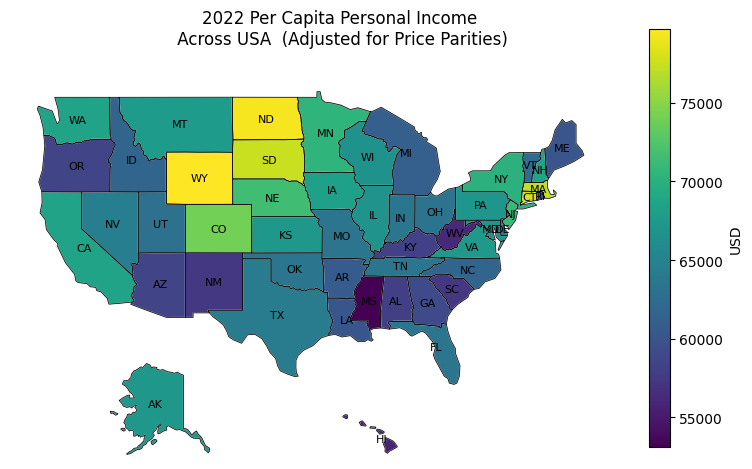

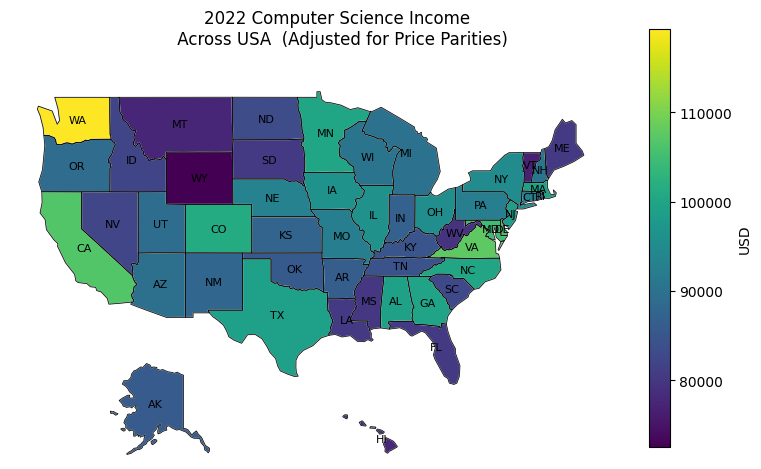

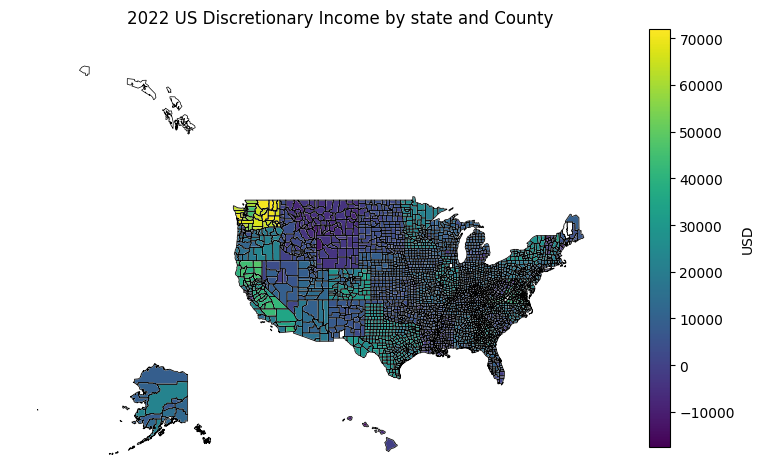

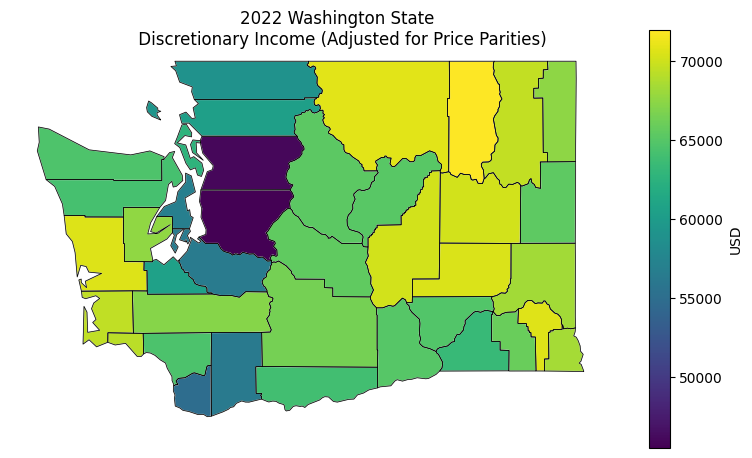

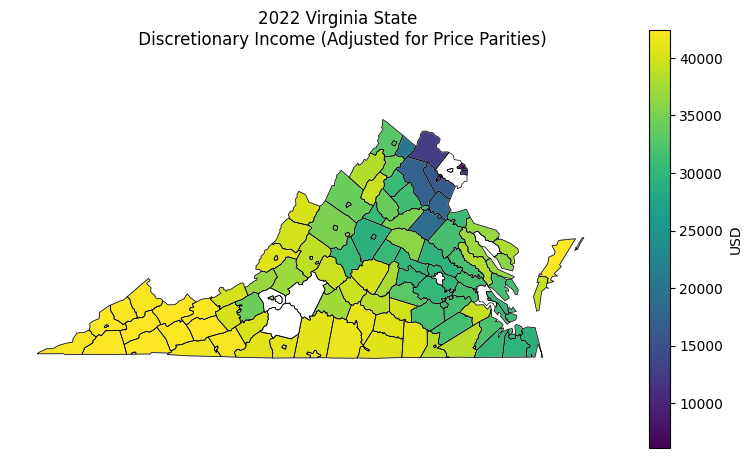

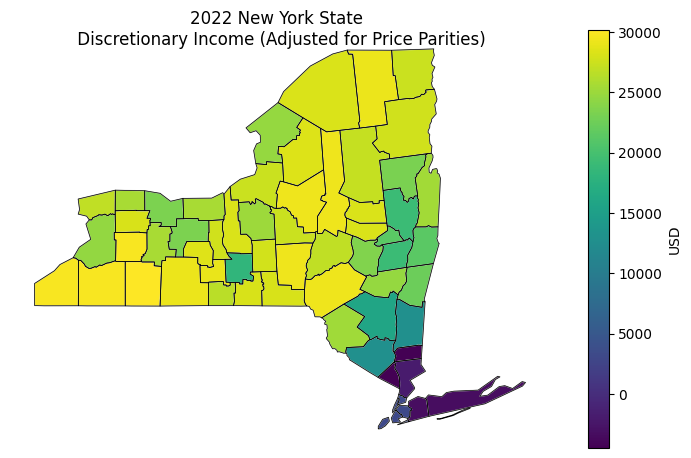

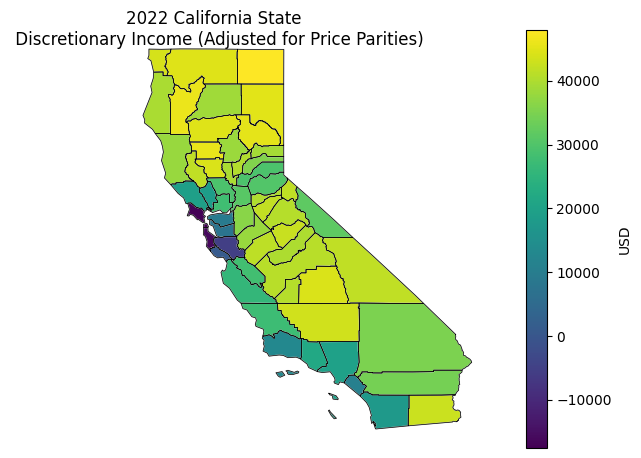

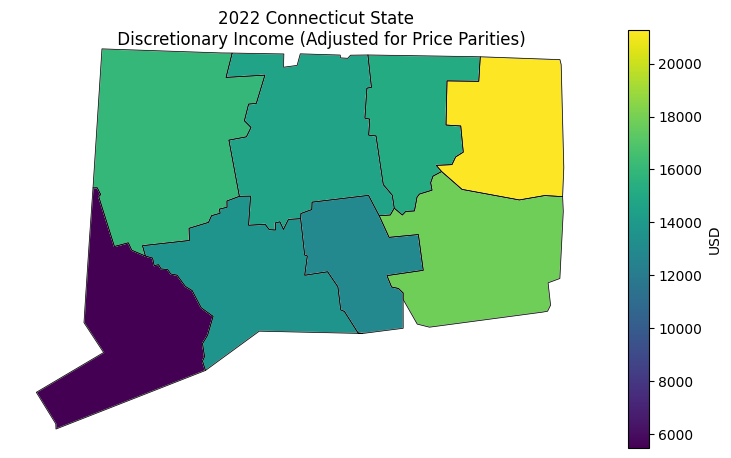

In [206]:
Chloropleth(SSRPP, 'Standardized Income',
            'Per Capita Personal Income\n Across USA  (Adjusted for Price Parities)')

df = WageVCostVOCC[WageVCostVOCC['Occupational Area']
                   == "Computer and Mathematical"]
df = df[['State', 'std Salaries']].drop_duplicates()

Chloropleth(df, 'std Salaries',
            'Computer Science Income \n Across USA  (Adjusted for Price Parities)')

#County Level Top 5 earning states
Chloropleth(CountyMap, 'Discretionary Income',
             'US Discretionary Income by state and County', Geodf= counties, ForCounties=True)
Chloropleth(CountyMap, 'Discretionary Income', Geodf= counties, ForCounties=True, SpecificState='Washington',
             Title ='Washington State \n Discretionary Income (Adjusted for Price Parities)' )
Chloropleth(CountyMap, 'Discretionary Income', Geodf= counties, ForCounties=True, SpecificState='Virginia',
             Title ='Virginia State \n Discretionary Income (Adjusted for Price Parities)' )
Chloropleth(CountyMap, 'Discretionary Income', Geodf= counties, ForCounties=True, SpecificState='New York',
             Title ='New York State \n Discretionary Income (Adjusted for Price Parities)' )
Chloropleth(CountyMap, 'Discretionary Income', Geodf= counties, ForCounties=True, SpecificState='California',
             Title ='California State \n Discretionary Income (Adjusted for Price Parities)' )
Chloropleth(CountyMap, 'Discretionary Income', Geodf= counties, ForCounties=True, SpecificState='Connecticut',
             Title ='Connecticut State \n Discretionary Income (Adjusted for Price Parities)' )






### Additional Visualizations